# Lab CNN

Create a CNN that can classify flower types

## importing relevant packages for pre processing

In [1]:
import numpy as np
import PIL
import PIL.Image
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import kerastuner as kt



2023-12-13 20:17:58.307862: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-13 20:17:59.031092: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-13 20:17:59.031199: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-13 20:17:59.191254: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-13 20:17:59.535166: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-13 20:17:59.538758: I tensorflow/core/platform/cpu_feature_guard.cc:1

## Pre processing the data set

In [2]:
data_dir = pathlib.Path("Data/flowers") # Setting directory path as a variable for the flowers data set

In [3]:
image_count =len(list(data_dir.glob("*/*.jpg"))) # Doing an image count to check the amount of images within the dataset
image_count

4317

In [4]:
list(data_dir.glob("*/*.jpg"))[0:2] # Listing some of the images, This is instance [0:2] is the first folder and first 2 images

[PosixPath('Data/flowers/daisy/5435521200_92029bbe2b_n.jpg'),
 PosixPath('Data/flowers/daisy/34518066912_0e432507bc_n.jpg')]

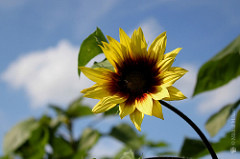

In [5]:
# checking to see if the images get displayed
sunflower = list(data_dir.glob("sunflower/*"))
PIL.Image.open(str(sunflower[0])) # checking first image in sunflower folder

### Creating and splitting the data set using keras utilities  

In [6]:
# I will have a few parameters that can change within the function these will include batch size, image width and height
# I will split the data in to a train at 80% and val 

def train_test_split(batch_size, img_width, img_height):

    train_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split = 0.2,
        subset = "training",
        seed = 123,
        image_size = ( img_height,img_width),
        batch_size = batch_size,)
        #labels="inferred",
        #label_mode="categorical",
        #shuffle=True)
    
    test_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        subset = "validation",
        validation_split=0.2,
        seed = 123,
        image_size = ( img_height, img_width),
        batch_size = batch_size,)
        #labels="inferred",
        #label_mode="categorical",
        #shuffle=True)
    
    # cardinality will now calculate the size of the validation dataset so that I can half it for the test dataset
    #val_batches = tf.data.experimental.cardinality(val_ds)
    #test_size = val_batches // 2 # test df is half of validation

    # Will now create the test dataset by taking half of the validation data set
    #test_ds = val_ds.take(test_size)

    # Adjusting the validation so that it will skip the test dataset
    #val_ds = val_ds.skip(test_size)

    return train_ds,test_ds


In [7]:
# testing the function with batchsize 32, height 180 and 180
train_ds, test_ds = train_test_split(64,64,64) # 64 is max batch size i could have 64 X64 means the model will run quicker

Found 4317 files belonging to 5 classes.
Using 3454 files for training.
Found 4317 files belonging to 5 classes.
Using 863 files for validation.


In [8]:
# checking to see the sizes of the train, val and test sets and at what shape they are

print("Training Dataset:")
print("Number of batches:", len(train_ds))
print("Shape of a single batch:", train_ds.element_spec)

print("\nTest Dataset:")
print("Number of batches:", len(test_ds))
print("Shape of a single batch:", test_ds.element_spec)
  

Training Dataset:
Number of batches: 54
Shape of a single batch: (TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))

Test Dataset:
Number of batches: 14
Shape of a single batch: (TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


In [9]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 64, 64, 3)
(64,)


In [10]:
# I need to also add class names so that the data has labels

class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


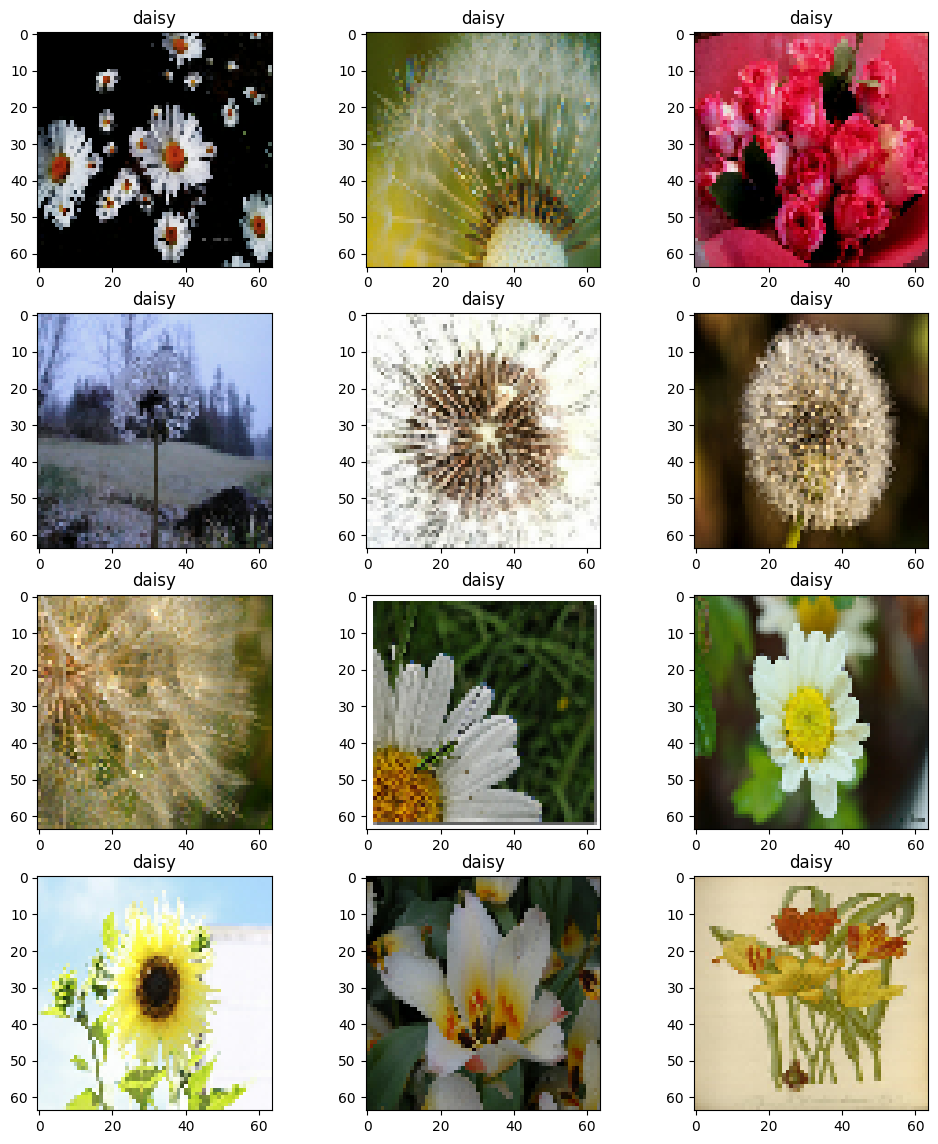

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,14))
for images, labels in train_ds.take(1):
    for i in range (12):
        ax = plt.subplot(4,3, i +1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        class_index = np.argmax(labels[i])

        plt.title(class_names[class_index])
        

## Building the model

I am going to use keras tuner to help find the best hyper parameters for my model. First i have to build a function that will have the different parameters that i will try to build the best model 

In [12]:
img_height = 64
img_width = 64

def model_builder(hp):
    
    model = tf.keras.Sequential()
    model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))

    # input layer 
    model.add(layers.Conv2D(
        filters=hp.Int("input_filters", min_value=32, max_value=256, step=32),
        kernel_size=3,
        activation="relu",
        padding="same",
        input_shape=(img_height, img_width, 3)
    ))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))

    # convolution network layers : I will use a for loop that will determine what the best amount of layers will be for the model using the keras tuner
    for i in range(hp.Int("n_conv_layers", 1,4)):
        model.add(layers.Conv2D(
            filters=hp.Int(f"conv_{i}_filters", min_value=32, max_value=256, step=32),
            kernel_size=3,
            activation="relu",
            padding="same")
        )
        model.add(layers.MaxPooling2D(pool_size=(2,2)))
    
    model.add(layers.Flatten())
    for i in range(hp.Int("n_dense_layers", 1,4)):
        model.add(layers.Dense(
            units=hp.Choice(f"n_nodes_{i}", values= [10, 20, 50, 100]), #changed these to small values
            activation="relu")
        )
        
    model.add(layers.Dense(5))
    model.add(layers.Activation("softmax"))

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])),
                  loss=keras.losses.SparseCategoricalCrossentropy(),
                  metrics=["accuracy"])
    
    return model

In [13]:
#hp.Choice(f"conv_{i}_activation", values=["relu", "tanh"]),

## Now I have created my model it is time to do run the keras tuner to find the best hyper parameters for my model

In [14]:
tuner = kt.BayesianOptimization(model_builder,
                        objective="accuracy",
                        max_trials= 10,
                        directory="tuner_results",
                        project_name="flowers",
                        
                        )

In [15]:
early_stopping = keras.callbacks.EarlyStopping(monitor="loss", patience=3)

In [16]:
training_data = np.array(train_ds) # change keras dataset to array
 

In [17]:
print(train_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [18]:
tuner.search(train_ds, epochs=5, callbacks=[early_stopping])  #validation_split=0.2,


Trial 10 Complete [00h 01m 59s]
accuracy: 0.5092646479606628

Best accuracy So Far: 0.6230457425117493
Total elapsed time: 00h 45m 00s


In [19]:
n_best_models = tuner.get_best_models(num_models=2)
print(n_best_models[0].summary())

best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
print(best_hyperparameters.values)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 224)       129248    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 224)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 224)       4

In [27]:
img_height = 64
img_width = 64

def model_builder_2(hp):
    
    model = tf.keras.Sequential()
    model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))

    # input layer 
    model.add(layers.Conv2D(
        filters=64,
        kernel_size=3,
        activation="relu",
        padding="same",
        input_shape=(img_height, img_width, 3)
    ))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))

    # convolution network layers : I will use a for loop that will determine what the best amount of layers will be for the model using the keras tuner
    model.add(layers.Conv2D(
            filters=224,
            kernel_size=3,
            activation="relu",
            padding="same")
        )
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    
    model.add(layers.Conv2D(
            filters=224,
            kernel_size=3,
            activation="relu",
            padding="same")
        )
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
              
    model.add(layers.Conv2D(
            filters=128,
            kernel_size=3,
            activation="relu",
            padding="same")
        )
    model.add(layers.MaxPooling2D(pool_size=(2,2)))          

    model.add(layers.Flatten())
    
    model.add(layers.Dense(
            units=hp.Int(f"n_nodes_1", min_value=0, max_value=20, step=1 ),
            activation="relu")
        )

    model.add(layers.Dense(
            units=hp.Int(f"n_nodes_2", min_value=0, max_value=10, step=1),
            activation="relu")
        )   
    model.add(layers.Dense(5))
    model.add(layers.Activation("softmax"))

    model.compile(optimizer=keras.optimizers.Adam(learning_rate= 1e-3),
                  loss=keras.losses.SparseCategoricalCrossentropy(),
                  metrics=["accuracy"])
    
    return model

In [28]:
fine_tuner = kt.BayesianOptimization(model_builder_2,
                        objective="accuracy",
                        max_trials= 10,
                        directory="tuner_results_fine",
                        project_name="flowers",
                        
                        )

Reloading Tuner from tuner_results_fine/flowers/tuner0.json


In [29]:
fine_tuner.search(train_ds, epochs=5, callbacks=[early_stopping])

Trial 10 Complete [00h 04m 47s]
accuracy: 0.24667052924633026

Best accuracy So Far: 0.6253619194030762
Total elapsed time: 00h 36m 45s


In [30]:
fine_best_models = fine_tuner.get_best_models(num_models=2)
print(n_best_models[0].summary())

fine_best_hyperparameters = fine_tuner.get_best_hyperparameters(1)[0]
print(best_hyperparameters.values)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 224)       129248    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 224)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 224)       4

### now i will train my model with best parameters

In [32]:
model = fine_tuner.hypermodel.build(fine_best_hyperparameters)

history = model.fit(train_ds, epochs=50,callbacks=[early_stopping])

Epoch 1/50
54/54 [==============================] - 48s 871ms/step - loss: 1.5386 - accuracy: 0.2724
Epoch 2/50
54/54 [==============================] - 56s 1s/step - loss: 1.3658 - accuracy: 0.4074
Epoch 3/50
54/54 [==============================] - 46s 853ms/step - loss: 1.1753 - accuracy: 0.5093
Epoch 4/50
54/54 [==============================] - 52s 959ms/step - loss: 1.0640 - accuracy: 0.5510
Epoch 5/50
54/54 [==============================] - 53s 979ms/step - loss: 0.9641 - accuracy: 0.6144
Epoch 6/50
54/54 [==============================] - 54s 993ms/step - loss: 0.9167 - accuracy: 0.6236
Epoch 7/50
38/54 [====================>.........] - ETA: 15s - loss: 0.8773 - accuracy: 0.6505

KeyboardInterrupt: 